In [1]:
import os
os.environ["MONGODB_ENDPOINT"] = "mongodb://pf.uni.lux:27017"

In [2]:
from mevlib.utils.utils import connect_to_mongodb
from pymongo import ASCENDING, DESCENDING

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

db = connect_to_mongodb()

In [3]:
flashbots_blocks = db.flashbots.flashbots_blocks
results_count = flashbots_blocks.count_documents({})
print("Total Flashbots blocks:", results_count)

min_flashbots_block = flashbots_blocks.find_one(sort=[("block_number", ASCENDING)])
print("Min Flashbots block:", min_flashbots_block["block_number"])
max_flashbots_block = flashbots_blocks.find_one(sort=[("block_number", DESCENDING)])
print("Max Flashbots block:", max_flashbots_block["block_number"])

Total Flashbots blocks: 1196218
Min Flashbots block: 11834049
Max Flashbots block: 14444725


Number of bundles with the type 'miner_payout': 61500
Number of bundles with the type 'flashbots': 2939980
Number of bundles with the type 'rogue': 247523


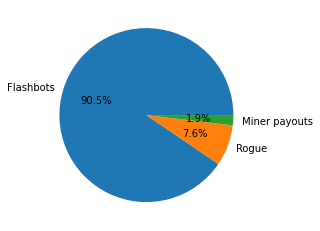

Total number of bundles 3249003
min 1
mean 2.716062624036756
median 2.0
max 42
unique number of bundles per block: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 33, 36, 37, 40, 42}
{1: 382955, 2: 269090, 3: 327785, 4: 74884, 5: 39541, 6: 30288, 7: 18658, 8: 14208, 9: 11147, 10: 14418, 11: 4300, 12: 2286, 13: 1595, 14: 1341, 15: 1499, 16: 708, 17: 337, 18: 291, 19: 326, 20: 482, 21: 22, 22: 23, 23: 5, 24: 7, 26: 2, 27: 5, 28: 4, 29: 4, 31: 2, 33: 1, 36: 1, 37: 1, 40: 1, 42: 1}


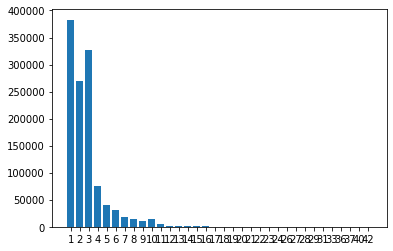

Size of bundles (or transactions per bundle)
min 1
mean 2.1556671385037194
median 1.0
max 700
unique number of transactions per bundle: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 1

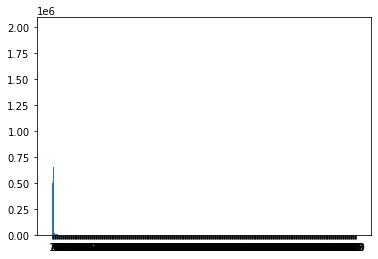

In [4]:
# Analyze bundles
import numpy as np
import matplotlib.pyplot as plt

bundles_per_block = list()
transactions_per_bundle = list()
cursor = flashbots_blocks.find()

miner_payout_transactions_per_bundle = list()
flashbots_transactions_per_bundle = list()
rogue_transactions_per_bundle = list()

for document in cursor:
    bundles_per_block.append(document["transactions"][-1]["bundle_index"] + 1)
    current_bundle_index = 0
    current_bundle_size = 0
    previous_bundle_type = None
    for tx in document["transactions"]:
        if previous_bundle_type == None:
            previous_bundle_type = tx["bundle_type"]
        if current_bundle_index != tx["bundle_index"]:
            if previous_bundle_type == "miner_payout":
                miner_payout_transactions_per_bundle.append(current_bundle_size)
                previous_bundle_type = tx["bundle_type"]
            elif previous_bundle_type == "flashbots":
                flashbots_transactions_per_bundle.append(current_bundle_size)
                previous_bundle_type = tx["bundle_type"]
            elif previous_bundle_type == "rogue":
                rogue_transactions_per_bundle.append(current_bundle_size)
                previous_bundle_type = tx["bundle_type"]
            transactions_per_bundle.append(current_bundle_size)
            current_bundle_index = tx["bundle_index"]
            current_bundle_size = 1
        else:
            current_bundle_size += 1
    if current_bundle_size > 0:
        if previous_bundle_type == "miner_payout":
            miner_payout_transactions_per_bundle.append(current_bundle_size)
        elif previous_bundle_type == "flashbots":
            flashbots_transactions_per_bundle.append(current_bundle_size)
        elif previous_bundle_type == "rogue":
            rogue_transactions_per_bundle.append(current_bundle_size)
        transactions_per_bundle.append(current_bundle_size)
        
print("Number of bundles with the type 'miner_payout':", len(miner_payout_transactions_per_bundle))
print("Number of bundles with the type 'flashbots':", len(flashbots_transactions_per_bundle))
print("Number of bundles with the type 'rogue':", len(rogue_transactions_per_bundle))

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([len(flashbots_transactions_per_bundle), len(rogue_transactions_per_bundle), len(miner_payout_transactions_per_bundle)], labels = ["Flashbots", "Rogue", "Miner payouts"], autopct='%1.1f%%')
plt.show()

assert(sum(bundles_per_block) == len(miner_payout_transactions_per_bundle) + len(flashbots_transactions_per_bundle) + len(rogue_transactions_per_bundle))
assert(sum(transactions_per_bundle) == sum(miner_payout_transactions_per_bundle) + sum(flashbots_transactions_per_bundle) + sum(rogue_transactions_per_bundle))

assert(len(bundles_per_block) == results_count)
assert(sum(bundles_per_block) == len(transactions_per_bundle))

print("Total number of bundles", sum(bundles_per_block))
print("min", np.min(bundles_per_block))
print("mean", np.mean(bundles_per_block))
print("median", np.median(bundles_per_block))
print("max", np.max(bundles_per_block))
print("unique number of bundles per block:", set(bundles_per_block))

a = np.array(bundles_per_block)
unique, counts = np.unique(a, return_counts=True)
D = dict(zip(unique, counts))
print(D)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

print("Size of bundles (or transactions per bundle)")
print("min", np.min(transactions_per_bundle))
print("mean", np.mean(transactions_per_bundle))
print("median", np.median(transactions_per_bundle))
print("max", np.max(transactions_per_bundle))
print("unique number of transactions per bundle:", set(transactions_per_bundle))

a = np.array(transactions_per_bundle)
unique, counts = np.unique(a, return_counts=True)
D = dict(zip(unique, counts))
print(D)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

# Are bundles always at the top of the block?
# If not, is it always because first come miner payouts?

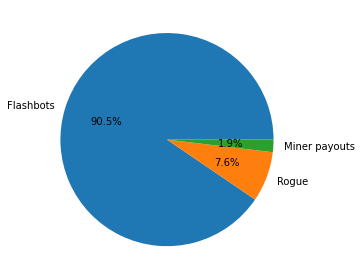

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([len(flashbots_transactions_per_bundle), len(rogue_transactions_per_bundle), len(miner_payout_transactions_per_bundle)], labels = ["Flashbots", "Rogue", "Miner payouts"], autopct='%1.1f%%')
fig.tight_layout()
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
plt.savefig("bundle_types_distribution.pdf", dpi=1000, bbox_inches='tight')

In [ ]:
# Analyze the usage of bundles
# There is good use cases: miner payouts, protection against insertion frontrunning e.g. trades on dexes like mistx etc, displacement frontrunning like arbitrage and liquidations
# There is also bad uses cases: insertion frontrunning and displacement frontrunning

# Taichinetwork is dead: https://github.com/Taichi-Network/docs
# Analyze mistx and others: https://extropy-io.medium.com/illuminating-the-dark-forest-748d915eeaa1 
# Ethermine https://u.today/ethereum-transactions-can-now-be-sent-privately-heres-what-this-means

# MistX has two routers: 
# https://medium.com/alchemistcoin/introducing-mistx-78066e140e13
# Alchemist Coin: MistX Router   0xa58f22e0766b3764376c92915ba545d583c19dbc 34715 flashbot transactions
# Alchemist Coin: MistX Router 2 0xfcadf926669e7cad0e50287ea7d563020289ed2c 12850 flashbot transactions
# 370 private transactions, 369 belong to flashbots, 1 is private 0x5e455a7ae266bdb2dcc0eb3a5d166a6a597277a805763c9bfeafa83ee33f453b
# Example of a private tx: https://etherscan.io/tx/0xfeac1034d48ca7a1da50c196dc7c6ef21c0bf248f5a77fc2c068d0b34f476608


# 1inch https://twitter.com/1inch/status/1334992381242961930?lang=en
# 1inch: 0x111111125434b319222CdBf8C261674aDB56F3ae 405 flashbot transactions
# 0 belong to flashbots, 4 are private
# 0x1111111254fb6c44bAC0beD2854e76F90643097d 31751 flashbot transactions
# 4632 belong to flashbots, 7147 are private





In [ ]:
# Analyze miner payouts bundle type
cursor = flashbots_blocks.find({"transactions.bundle_type":"miner_payout"})
payouts_per_miner = dict()
payout_miners = set()
for document in cursor:
    payout_miners.add(document["miner"].lower())
    current_bundle_index = 0
    current_bundle_size = 0
    current_eoa_address = None
    payout = {
        "total_miner_reward": 0.0,
        "recipients": 0,
        "first_transaction_index": None
    }
    for tx in document["transactions"]:
        if tx["bundle_type"] == "miner_payout":
            current_eoa_address = tx["eoa_address"].lower()
            if current_eoa_address != document["miner"].lower():
                print("miner and eoa address are not the same", document["block_number"])
            if not current_eoa_address in payouts_per_miner:
                payouts_per_miner[current_eoa_address] = list()
            if current_bundle_index != tx["bundle_index"]:
                payouts_per_miner[current_eoa_address].append(payout)
                current_bundle_index = tx["bundle_index"]
                payout = {
                    "total_miner_reward": float(tx["total_miner_reward"]),
                    "recipients": 1,
                    "first_transaction_index": tx["tx_index"]
                }
            else:
                payout["total_miner_reward"] += float(tx["total_miner_reward"])
                payout["recipients"] += 1
                if payout["first_transaction_index"] == None:
                    payout["first_transaction_index"] = tx["tx_index"]
    if payout["recipients"] > 0 and current_eoa_address:
        payouts_per_miner[current_eoa_address].append(payout)

# How many miners use payouts?
print("Total miners", len(payouts_per_miner.keys()))    
c = 0
for miner in payouts_per_miner:
    print("miner", miner, "payouts", len(payouts_per_miner[miner]), 
          "recipients", sum([x["recipients"] for x in payouts_per_miner[miner]]),
          "min", np.min([x["recipients"] for x in payouts_per_miner[miner]]),
          "mean", int(np.mean([x["recipients"] for x in payouts_per_miner[miner]])),
          "median", int(np.median([x["recipients"] for x in payouts_per_miner[miner]])),
          "max", np.max([x["recipients"] for x in payouts_per_miner[miner]])
         )
    print("first_transaction_index sum", sum([x["first_transaction_index"] for x in payouts_per_miner[miner]]))
    for payout in payouts_per_miner[miner]:
        c += 1
        
# How many payouts in total?
print(c)

# How many payouts per block?
if c == blocks_miner_payouts:
    print("blocks only contain one miner payout bundle")
elif c < blocks_miner_payouts:
    print("Error something went wrong...")
else:    
    print("blocks contain more than one miner payout bundle")
    
# Do miners never pay for payouts?
for miner in payouts_per_miner:
    print("miner", miner, "total_miner_reward", sum([x["total_miner_reward"] for x in payouts_per_miner[miner]]))

# Do miners mine their own payouts?
print(len(payout_miners))
print(payout_miners)

In [ ]:
# Analyze flashbots bundle type
insertion = db.flashbots.insertion_results
flashbots_frontrunning = insertion.count_documents({"flashbots_bundle":True})
print("Total number of bundles:", sum(bundles_per_block))
print("Flashbots frontrunning bundles:", flashbots_frontrunning)
print(flashbots_frontrunning / (sum(bundles_per_block)-flashbots_frontrunning) * 100)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([sum(bundles_per_block)-flashbots_frontrunning, flashbots_frontrunning], labels = ["Other bundles", "Insertion frontrunning bundles"])
plt.show()


Total blocks: 774725
Blocks containing at least one frontrunning attack: 80093 out of 774725 10.338249056116688


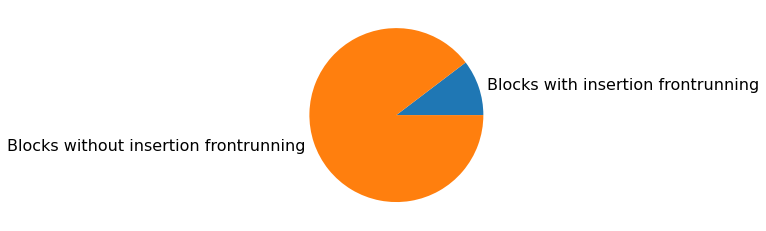

Insertion frontrunning attacks between November 23, 2021 and March 23, 2022: 99928
Insertion frontrunning attacks between November 23, 2021 and March 23, 2022 using flashbots: 81089
Insertion frontrunning attacks between November 23, 2021 and March 23, 2022 without flashbots: 18839


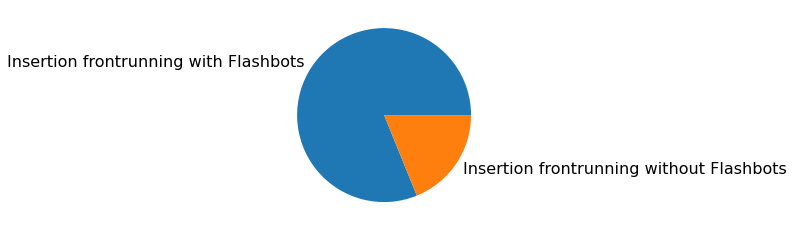

Public insertion frontrunning attacks: 5601
Private insertion frontrunning attacks: 13238


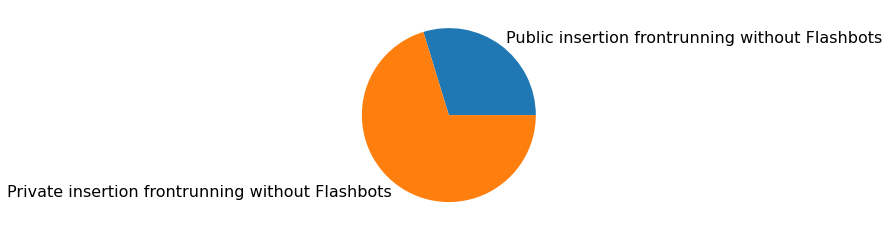

[{'block_number': 13670029,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x4739f60f65db2a37a27792daa81c88b0fa5d4eaa7df7ebb609c98b05e2676900',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0xa571b391054de7a68dae4cc4f625a9a9e7a3002ae74487a8468de0b4f7899a65',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13670053,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1c3ff92523C0656a32f31507ccEb20857Cc80429',
                    'hash': '0x6f056f5c298720dde19aaede8233a72dcc6c893ed9f670db937685ee0e43ff58',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1c3ff92523C0656a32f31507ccEb20857Cc80429',
                   

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13677923,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x38df07cf6df162494013ae6a55fd4e80c35ef6362f7880075b574f7f2b74623e',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0xf0a3babb52e4a0d9c1011512cc16b620efe27c09d39b9b796376c5e08f76acd5',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13677926,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1c3ff92523C0656a32f31507ccEb20857Cc80429',
                    'hash': '0x83f79464c2c712787f4dd77c4500557fec9c05128117147f33250c0f606b20c2',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                  

  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x94dDD5e97de3A659A1b10E2845857eDb01883619',
                    'hash': '0x7036a171006ccb7a7b8966e57273429985f4dc61c24a3a6ec99abf2e37b2dd04',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0x94dDD5e97de3A659A1b10E2845857eDb01883619',
                    'hash': '0xd0014560f672a864588f611c4f6c0266342f063b0317a5250c7b58f57bed9332',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'}]},
 {'block_number': 13684794,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x7B34d49FABeeB86d785DB00cBe5B730B2AfbF2Ea',
                    'hash': '0xc8728bf15a6aaf70ae28ee5c48cf615b4e8bf7845fa73664ca6b6eaa26dd8ce2',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0x7B34d49FABeeB86d785DB00cBe5B730B2AfbF2Ea',
                    'hash': '0x56dcc43fc700becb

                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13692225,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x2619228a63fe63b3af14a41d3da6a36669b96934591ebfcfcd83047b7a65c108',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x4682eac855c415c4dc8cba302710d928471630638209623400f6cc464fdb440a',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13692227,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x7B34d49FABeeB86d785DB00cBe5B730B2AfbF2Ea',
                    'hash': '0xedd969d29f39e9f797fdf212f60663f74e8f5710631972b8df3a31246a13ad7a',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                  

                   {'from': '0xE5E54C60Ef117265eEF85f1Ac666d8e640fe92b6',
                    'hash': '0x430ac5b93228b2ce4eb162df8ef56e607220a59d0d79814d38d5ebc632f0883a',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'}]},
 {'block_number': 13698894,
  'miner': '0xB7e390864a90b7b923C9f9310C6F98aafE43F707',
  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x8c5977b4f8d588fab2324d51bf472572a35a62883774aef61741759c063dff3c',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x3d36add57b243d7893577588e361eb51a7724516670168547ea1adaa1ba3ffed',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13698909,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x24DBfaf6528D7bc3F2847a2972856e191d9F1364',
                 

                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'},
                   {'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0xd159452602b91a91fe5a4d02bb5c575dde4ad238fc38a3f0dcd5a334c35aa12c',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'}]},
 {'block_number': 13701184,
  'miner': '0x2DaA35962A6D43EB54C48367b33d0B379C930E5e',
  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x2438a5c57fdf56ea07cdfa5c1ae972a4a6a259581d9ca5123d342a148fc65d5b',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x7c8c5dbc585657da634ed284d20f0385c90e42a4d91f32b44048bdb23c11af5a',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13701191,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': 

  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x94dDD5e97de3A659A1b10E2845857eDb01883619',
                    'hash': '0xe7e2eba2bdee4ae916942f7a5ad98132d806247859b60d785a0c53e16668a221',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0x94dDD5e97de3A659A1b10E2845857eDb01883619',
                    'hash': '0x2d54043eac11734eba7e2c7b3ee8125c105ec3947f90b295d5c2db532f0fb1c1',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'}]},
 {'block_number': 13705436,
  'miner': '0xc365c3315cF926351CcAf13fA7D19c8C4058C8E1',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x6d732f1841dfd352c56b66926f75260561e378341dfa00f2b829d677bbf1ac73',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x90b062fae2b97f6e

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13707220,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xE5E54C60Ef117265eEF85f1Ac666d8e640fe92b6',
                    'hash': '0x746be6415622b3f5991653e9785b31a4b1ffe1e99d5b8b97c94322649c5cc9aa',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0xE5E54C60Ef117265eEF85f1Ac666d8e640fe92b6',
                    'hash': '0x83ea86789c2572c9e4f46d874c8c8bb37bd4ed5b11adf8399df8107d5863d4ee',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'}]},
 {'block_number': 13707229,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0xfe8cb108041b78639cd36f856858bd79e24a39c3fe76f1d251337fbae737c5ff',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                  

                    'to': '0x00000000726422a6fECb4759b44D47E48Cf746aa'},
                   {'from': '0xF5D463E6050f59e47750cb2aF4047CC536D36103',
                    'hash': '0x430fa6da30d72b7ec96dbeef3ef80b13b80134847fbf5b1845fc916baf0b862d',
                    'to': '0x00000000726422a6fECb4759b44D47E48Cf746aa'}]},
 {'block_number': 13709536,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x24DBfaf6528D7bc3F2847a2972856e191d9F1364',
                    'hash': '0xfc6b40f56cddb1ca36e4ebaf36d69814f8ca2b6ec8ca7770f41f910ebf868162',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0x24DBfaf6528D7bc3F2847a2972856e191d9F1364',
                    'hash': '0xf8e9dc74dffa8d200668e69b8ad21275973446e3eaecf1e63f53e98f1b708a97',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'}]},
 {'block_number': 13709547,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': 

                    'hash': '0x7291f1682b154d5696bf5dcdddb67e395abc100722a6d0e36c4b87e708917fda',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'}]},
 {'block_number': 13713170,
  'miner': '0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x804e65e6ad0f61797a2407e5b14fb075ad5b58107c0eccf0468abf3f9ff2206e',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xd067128e20dbc5ce888e2fd396b45b8af322ba890db8d5b095027e846aa27061',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13713217,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1c3ff92523C0656a32f31507ccEb20857Cc80429',
                    'hash': '0xaca5bcf7f9687f967f9de27b16dbf733e95beb90d09761aee77d9248d2c4

 {'block_number': 13727256,
  'miner': '0xCD458d7F11023556cC9058F729831a038Cb8Df9c',
  'transactions': [{'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x05cdbbc93c733f9856460e0500305227d9d5cb43d508fba6e811cc53d563e11f',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'},
                   {'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x510ea543c23a36898f56f2eaa731914a24a76af2970a72a38cfb1981b3206109',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'}]},
 {'block_number': 13727257,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x9ed10d5e1a612d03aebd97c6ae9d4cc3c16628359d1565faac90ed47e1c7feef',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                   

 {'block_number': 13733666,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x7857bffebd86ef061ddbf39cec8dc3569361e22351e3d3f18acfb13c76289e86',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xb9a07f3022b7395ce5a87f7d5b4830656c9ef6bb8f3f92ce0569b6d0035739d4',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13733666,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0x5c5014F07a293461B947DC576A640B702BEA7438',
                    'hash': '0x3e7c7f3298024aa901fd2ecd7f49748c3a3258e96e320b010fea428c60320804',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0x5c5014F07a293461B947DC576A640B702BEA7438',
                   

                   {'from': '0xF5D463E6050f59e47750cb2aF4047CC536D36103',
                    'hash': '0x65c0c343a5167cd71525d6d23e99f9eb8edf089f72d09f9b3e2ddd0b1ce723c8',
                    'to': '0x00000000726422a6fECb4759b44D47E48Cf746aa'}]},
 {'block_number': 13739224,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x83b4F74296738d8C2e15bD7c1f4a19Df122354f5',
                    'hash': '0x5d11d98d574c6f27cd7bf424f8d5278fcecf722ec622edc26d86ce4d4886c36f',
                    'to': '0x0000000000d41C96294CCdaC8612Bdfe29C641aF'},
                   {'from': '0x83b4F74296738d8C2e15bD7c1f4a19Df122354f5',
                    'hash': '0x463f888ac8bab60c99bdb145c5044255c3555207c212571ba3603925fca28440',
                    'to': '0x0000000000d41C96294CCdaC8612Bdfe29C641aF'}]},
 {'block_number': 13739290,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                 

  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x0fa0e29d8945eec0dc29679991bd55cb7b7a38cb19200e8e1ce3b6be3b7f0186',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x88142684248276b1b33c2a1bbbbe34fbac6f873bd32f75869fb35fcaee4ce71f',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13745169,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xbe00df36635e2f88c5c6aefe79e6c023d127066148f797b18857b0350e7a9a31',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x6683e4dec9b1ed2fdc19ff37a358268fa8cce0143c4908a4707fe45bc4dd8e6b',
      

 {'block_number': 13751885,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0x45F4150973e703d9a7943f7E958d38e7F6A0B454',
                    'hash': '0x5b145e941fe3055b1c910a9a91820ed4c0a377cf35148ba6024993afb3780f2b',
                    'to': '0x828a2D99bb1a31cA0Eba80f3e01db8dae652A1E3'},
                   {'from': '0x45F4150973e703d9a7943f7E958d38e7F6A0B454',
                    'hash': '0x1d1b6a63321e3bd612b9741b036ba1cd9f1379df4d6138d2cf557f9b43ec09cf',
                    'to': '0x828a2D99bb1a31cA0Eba80f3e01db8dae652A1E3'}]},
 {'block_number': 13752031,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0xecea3b4150643242eae400f386cc33f368d0a6d1fa2a388f2d6456c79bd81598',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                   

                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0xc12b41b40e009bbf8236612b4a78bffa962632a2ae1d5baf0d99d660353f10cc',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13756373,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x605a9743e711ffa220d5bd0cf1b644a1ad78ea67b42fa3699710f6686307edd9',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x09a259e6ee533395e18e5369b2660a0a1828fec2b6e355d046cce6fb3a8b59e9',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13756408,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': 

 {'block_number': 13761750,
  'miner': '0xc93452A74e596e81E4f73Ca1AcFF532089AD4c62',
  'transactions': [{'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x80629a40301291f77b821128b283b34efd1c135a29ffd3e89cdf883c2a939ae7',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x117a02efc8ee9ab38b1a6b79468de96b1f18bac003e59a149c0f3f036dca9333',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13761769,
  'miner': '0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x0357bad797a80bb15445c215803ce2c68b1dfb371c1709bff44543600a8570cc',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                   

  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0xcf270a7c4d9e457b5dadc44665fd551d9c115da8d29c95e573a479cc9e370f08',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x125ecd48e1a3e765576aa43599ac9bc993815af63d59a55cc22c423a6978ed52',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13767686,
  'miner': '0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x8e57a39637c0dc4165686c514d3ae3b31db06f0615399355a59c9eb1ae66d1f7',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x31768bdc7f39feac01a3663e788d9804c1a6b05af497c29f00378373e782edf3',
      

                    'hash': '0x09c1617ddefbe46277b5c6cccb3e3d0d75a725186e8112d02a0976e11a7bd008',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0xb7aB1DE5b259a880c4BB5451bDbE6f80F3798538',
                    'hash': '0xa6946b48522b712e47a45425bca21c595a0b394360d366d337829024e5bc6c7a',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'}]},
 {'block_number': 13772864,
  'miner': '0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x2ac3606b5f06d27b2f7a258f3295c7d9a0dd7d189a658d336acef0ad8ed8db33',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xdf5e4a2f30b7a0853f01a26f41808dd8bd2cdf10ca881e4a3b5e073e0fd41667',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'bl

 {'block_number': 13777550,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x34fca68c8919613e2948325adc0d81a68b85d531d3874f65c82fe685968e85d0',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xd6e7325ad60d03048a1ea15d0fc12d9c7eedf7074cc1c9848762bbcac4f03544',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13777556,
  'miner': '0xB7e390864a90b7b923C9f9310C6F98aafE43F707',
  'transactions': [{'from': '0x5c5014F07a293461B947DC576A640B702BEA7438',
                    'hash': '0xe48bf8c70088d6e2b89795e854aef6d5a6306381068713322224f6907204769a',
                    'to': '0x000000005736775Feb0C8568e7DEe77222a26880'},
                   {'from': '0x5c5014F07a293461B947DC576A640B702BEA7438',
                   

                    'to': '0x2AE0d7d7e9c7880F01e530c731F21D49BE179732'},
                   {'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0x6111513b11573e60c782ed8e29d522457b98890e7c65dff18fa61f151cd4b807',
                    'to': '0x2AE0d7d7e9c7880F01e530c731F21D49BE179732'}]},
 {'block_number': 13783846,
  'miner': '0xB7e390864a90b7b923C9f9310C6F98aafE43F707',
  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x8d5c53c28850187a1b109e41f520b6f347d306897be86fae605a42a8892c525f',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x95c2303535c5e8546e53cc62267ef2b918f0efb010c6c5b6c739c371ebcc17f8',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 13783853,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': 

  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x69e2827c7a09833a61d5cd4b0ab36b0b154485a39f9f26d9432ab49bb09ec21e',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x45c08fe2f0c48754c950587aa158d91aeb2121d8f5cca24363ee099c2734fc28',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13791105,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x43922ff779f55ad6e5356bcb971b66a6f62ff93090b912ae8caeb2b11195585c',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x6bf7cd797adecd22

 {'block_number': 13795781,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0xb9898b310e9f2e860623515705fd8f1d38441959f67d9aaa5abc678b34a7c04b',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x57849c146bb5296caebc6a2bdbc7fa03e972483273970c1daead7d8e7537fa52',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13795798,
  'miner': '0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x3eca40b3f85df0baadd100b3b2e66191ef50579e2fd46bfea3a3699e6d784f57',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                   

                    'hash': '0x8e5588f7c62ee81ff1b110a38ec4a0ddff3096cf382f9509ba883f39a1bb029f',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 13800754,
  'miner': '0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x48ae6a05f66c2fcfa6c574b0ee92f6840149da3602c3b2a1af354e89a948c392',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x639a18db310a3637f36df01a881516671f94193d80ec36882e9e9a75c8c51fe0',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13800817,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0xd115bf59ead64b071206f02e2a997e1716c6011b92e8622dc4eacdbc9e0b

                   {'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0xf421e4656c7e76a660185cc820aa3c8a69c4d78646517dcfa8ad86ff52390da1',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'}]},
 {'block_number': 13807338,
  'miner': '0x0708F87A089a91C65d48721Aa941084648562287',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xd0e76d8c817109ac667dba79c9ebf5e04faad8ef0cb038589e1d2a3775431fd3',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x7e1c05f010d681c29aae6ff7a1aabacc206fa08912a319e000a2be1bd2919ea4',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13807376,
  'miner': '0xc3348B43d3881151224b490e4aa39E03d2B1cDEa',
  'transactions': [{'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                 

 {'block_number': 13811478,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0xf5d740f6156ea9555ee982e9a329629671bf058a0b5dca8babcb2a419f92aff8',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x534936744d77ff6790d7aee906cb91df18583c914ebdd215bb09bd2471df6047',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13811478,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0xac9333d02c1c18114d7a1dc2f152baeee66b6518ac8f7a3fd61ccefd7b9aea1d',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                   

  'miner': '0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x019d6ff684c3935084eddeadb295ef91a5d9bd05abae22697ff1768625849c55',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x40133ae96cc21a3638fb4dec844fcb3a27ec11a1ac846621e76a064c0e6dfceb',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13814683,
  'miner': '0x8F03f1a3f10c05E7CCcF75C1Fd10168e06659Be7',
  'transactions': [{'from': '0x26cCc3a2052Be5898d60683C7BB621047153bb19',
                    'hash': '0x978030b5a9ff135f0e4404cfe6d6a82df8848b701a54e55399a79307077705ca',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x26cCc3a2052Be5898d60683C7BB621047153bb19',
                    'hash': '0x7e95e078ad3e965a

 {'block_number': 13823135,
  'miner': '0x0708F87A089a91C65d48721Aa941084648562287',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x046a8bc1d9c441982629e68ea3314e7825416a0f194430f34ec2ee7708500f08',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x84a2eba63f7f4bae08f730810762cc9eeaee8a08605186e6349ea22a6162bcbe',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13823139,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0xb7aB1DE5b259a880c4BB5451bDbE6f80F3798538',
                    'hash': '0x6880280a886069373a85e7f95326aa8bd16673115332300215d490541c8e2f4c',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0xb7aB1DE5b259a880c4BB5451bDbE6f80F3798538',
                   

                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0xa6Ae57b1dA8238Cd149bC718c40578E4620b752c',
                    'hash': '0xea68e1084a5d7cb3cdc698692caab4fc3ee31a9bdfe4824c2fa1aefe3dd5df6d',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'}]},
 {'block_number': 13829996,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xb46d1604c921940524959d4b909b0a526fbadbe93644931181ae3be8e2f3f095',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xb2e83166be0258d955fafba0590cfe21335901f98d596c70484209820c69974e',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13829996,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': 

 {'block_number': 13836609,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x73f09d609e09d930f2cf7425907df3d59ccc99fdd9ed4a6b549e049cd22e43bc',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'},
                   {'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x2d9d7174a45d7bafd942d82ac03693da3c6122b5719327ed7c5598c133e849cd',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'}]},
 {'block_number': 13836678,
  'miner': '0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8',
  'transactions': [{'from': '0x83b4F74296738d8C2e15bD7c1f4a19Df122354f5',
                    'hash': '0xeacbe882d1db341e557553f3482a6587509986eae8d3a2f72c5a2acd0f353d1c',
                    'to': '0x0000000000d41C96294CCdaC8612Bdfe29C641aF'},
                   {'from': '0x83b4F74296738d8C2e15bD7c1f4a19Df122354f5',
                   

                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13842828,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0x0255101fc4bb597dfec7ed5a6eba58dc9670b45ce5dd2cce6b5aeca787aea39d',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0x444626bdf4997cc343f65719ce0abd580a46f27e4a36b3341d72bb58e1d7e88b',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'}]},
 {'block_number': 13843015,
  'miner': '0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8',
  'transactions': [{'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x40872aee32aa815bf8995d64e9943d4eae0869e937cbb6278f6e64f88613a06b',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'},
                  

                    'hash': '0x59543763ea7815fbe0bd42e1d32c38f34a6ec8c6fe19bb8d4b59e36efaea3f01',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'},
                   {'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0x0d73830aed1da6ac385ad6fe475f64d93547eff706af10efcf2d0b2615829937',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'}]},
 {'block_number': 13848953,
  'miner': '0x0708F87A089a91C65d48721Aa941084648562287',
  'transactions': [{'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0xe52a8948b03424a9b032f2aa6eb5085ba4e0b185b69205108bda15e418635b75',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x676f9c9505f2b949de98496f28e872eea9ac6009bec28c443394b5bbacc49e91',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'bl

 {'block_number': 13854606,
  'miner': '0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5',
  'transactions': [{'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0xb64aa2155a2d72c6cb283a45411e5e3ea432bb0e70bb39719757fdf49496f986',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'},
                   {'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x6cb49a00c25d8e8a4ced98861bf2b5755edc2959f4e601d6f2277f988aabe348',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'}]},
 {'block_number': 13854735,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x6066f007f0e19949283a581968153c1ef7e3c36b150b4b492c77916efa0440b9',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                   

 {'block_number': 13862300,
  'miner': '0xc3348B43d3881151224b490e4aa39E03d2B1cDEa',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xaa961d8d8105d2e94000ae5dcfdc4cad25bb36027840d7591780d801c2941ec5',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x00e2a04575b7875965ba2941662568fbadb4ccf0cd8298f37fae128ebc76397d',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13862300,
  'miner': '0xc3348B43d3881151224b490e4aa39E03d2B1cDEa',
  'transactions': [{'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0x86746098883ddc90665b94038e095d3fcaec06ab8851cb99c7be7350cf136300',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                   

                    'hash': '0x44a5746464654bc93fad7bb0d4014f90dab3790356e779f12c97ff6e2a11c196',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13866509,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                    'hash': '0xe5de0b7ea687c4c9a873b70ed61092c28e07e52ef8abbeb763bbae8ba323aee4',
                    'to': '0x499dd900f800FD0A2eD300006000A57f00FA009b'},
                   {'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                    'hash': '0x2b8638428cdc305b19f2ee2e44311e273aad4b53b05772be7a26742c7c4895f7',
                    'to': '0x499dd900f800FD0A2eD300006000A57f00FA009b'}]},
 {'block_number': 13866509,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xd6f660Aea79dABd5220332a73D4effaeB70B3547',
                    'hash': '0x8e189e80e36701b67b4ac71178a30c41f08ee46b9c2fd490b177dc63b5c0

                   {'from': '0x1c3ff92523C0656a32f31507ccEb20857Cc80429',
                    'hash': '0x18fea78ee0a73b5e4de1a854107b2611270c73ec9a1ac327be21d4c323e0cd67',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13870296,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0xb7f1a7b9af6217cc78ab0e040e28f3a2366e039c2ded36c405a561dda473dc6b',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0xf4e6846dd94033bbb76806e06c5f1fb8fb93d917daa2d7eb74e49f7dd79fdb9e',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'}]},
 {'block_number': 13870327,
  'miner': '0x03e75d7DD38CCE2e20FfEE35EC914C57780A8e29',
  'transactions': [{'from': '0xA977afAd219b3b2853db05045Ae9e8cE13b4B2C5',
                 

                    'hash': '0x667c0040edf69e325ff967017032c087eeb1454dd29be4d1b76cbc42ccaa6d50',
                    'to': '0x00000000726422a6fECb4759b44D47E48Cf746aa'}]},
 {'block_number': 13873229,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0xd6f660Aea79dABd5220332a73D4effaeB70B3547',
                    'hash': '0x287dd72e81d76b7bf6ef27a8d71b9e4fc23d81eb7f33687e3519caf2456464c5',
                    'to': '0xa405e822d1C3A8568c6B82Eb6e570FcA0136F802'},
                   {'from': '0xd6f660Aea79dABd5220332a73D4effaeB70B3547',
                    'hash': '0xaf3b1c43fb223f5cb49405e1e12fd3efa392a0274e7ffe4774cd270614577876',
                    'to': '0xa405e822d1C3A8568c6B82Eb6e570FcA0136F802'}]},
 {'block_number': 13873233,
  'miner': '0xCD458d7F11023556cC9058F729831a038Cb8Df9c',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x41112d4c477e9eb299424b49ef01eda5c511c74d1388384cba5ea587a11a

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13875628,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x897e2b780557ff572b20ed0877bbe8a8b6bd585b720bf70e1cec39f223773514',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0xf13acbccac8869c143753a596fe519ff1063ea39a2ac05d61411c6673d7dfa84',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 13875628,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1c3ff92523C0656a32f31507ccEb20857Cc80429',
                    'hash': '0x9513b6f90735f05f2fc1edf738ac55c4ce2cf04a5be76dbd768be16a35cd8193',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                  

                    'hash': '0x2193160cf1882a3782695a12f156fa6808b65b0576f881930ee16e9d854c1643',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13879749,
  'miner': '0x4069e799Da927C06b430e247b2ee16C03e8B837d',
  'transactions': [{'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0x7903fc804c1c3427e4ff4fd38ebd5af24d11fecec362d6f2c64cac4696c2a4ce',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'},
                   {'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0x8f377e95353ed7264fd4579e4c5b704e5bb42d08638da73248e74f16ab71bfef',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'}]},
 {'block_number': 13879827,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x8a86e3c1de3ae9c7c3a9af870fbe3daf7b099ea8cb7e57c33a2bdcff6ab6

 {'block_number': 13884986,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0xf31c1ad89135ae7ed97cb923014d4b56eaa2f23d85981fd96b10d4848b04624e',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0xbc4cea20002e118e2243f0b93a5ddb6f696492f575366abd13bbadcd3a54cce7',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13885001,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0x7d0ea3139d14a2a885902b84f95ca9422e88d2472f4359a49d4d4df92cea6058',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'},
                   {'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                   

  'transactions': [{'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                    'hash': '0x9cfd29d43754cdc2f4986802ed96ece8609d7d901ae2becb81a3cb192a8d9919',
                    'to': '0x499dd900f800FD0A2eD300006000A57f00FA009b'},
                   {'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                    'hash': '0x46a5b09624df34cd4f5952bad5e3d034159d9926205d767644fd7130ca71a0cf',
                    'to': '0x499dd900f800FD0A2eD300006000A57f00FA009b'}]},
 {'block_number': 13889922,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0xccece9b645448720b52d08d3557c36dd0258e06e9455026af8bb6144ada27533',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0x978bb3746dc1f76b85bc2b8f37f5973033beb66a07d4b32b6565f4a5acff2d59',
      

  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x2090ba0410af1bfe51ae28075a64c742456a1834469c5ebe3c6f042a38cf9509',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x20b3883981c659c68165fe951fb52787c8851e76906ded38a5cc91c7df65931a',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13897421,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0xfbffc2e1c57a4aff95f75327b7cab66101ff96fe50074fde9cc870e2564de62d',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x018360773c0923479d5ee0c851a0eb98368ebea738c1421c6a0d64080c997ec7',
      

  'transactions': [{'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x1c51f3146dccd5917819ce9f242aa7f09aa96f4b7b2d332b0f0af125168875eb',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x5768557a31574c117f6721d7ba95c0fef7ddc7fe93c06864bead2b276505d7ff',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13900900,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xd6f660Aea79dABd5220332a73D4effaeB70B3547',
                    'hash': '0x762d611e8c3db778f593e7c2e5f42818bfd68b9587cd406eb2e8888c2bafe0f7',
                    'to': '0xa405e822d1C3A8568c6B82Eb6e570FcA0136F802'},
                   {'from': '0xd6f660Aea79dABd5220332a73D4effaeB70B3547',
                    'hash': '0xbf1fe68e3ee04cf147d0024890ef8ea887ab86fedd5d08568d5d4cb52284403e',
      

 {'block_number': 13906293,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0x067f05985891ca8419267f6367a7c8d8fd9c9265306dc636620c3893cc0b92e6',
                    'to': '0x2AE0d7d7e9c7880F01e530c731F21D49BE179732'},
                   {'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0xc3e01cdc3fd4db6411b2b7d4e4898db156868d7c618a1fba5a4103140e78e7cc',
                    'to': '0x2AE0d7d7e9c7880F01e530c731F21D49BE179732'}]},
 {'block_number': 13906339,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0xa094946e5e931a42239920af5e633974ddca75f1820c1fa5bb3e651b2bcbe09b',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                   

  'transactions': [{'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                    'hash': '0x387e41e6294f5277627b14fe917627755e66b78203d56ed5a682017ad2b98c4e',
                    'to': '0x499dd900f800FD0A2eD300006000A57f00FA009b'},
                   {'from': '0x0000000000C521824EaFf97Eac7B73B084ef9306',
                    'hash': '0x2e5e91be1129943d6a1f32864028ed70e954e0782392563e17211a4a8c1e547a',
                    'to': '0x499dd900f800FD0A2eD300006000A57f00FA009b'}]},
 {'block_number': 13910746,
  'miner': '0xc365c3315cF926351CcAf13fA7D19c8C4058C8E1',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x91d3729e321fc0707439e9d476fb16451962b56809d0c099b90174239ec869c2',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0xe1fe55181b58ea7bf42ebf395e98a9ef67d3304bfe04b5887f8d39ca7fdbd409',
      

  'miner': '0xB7e390864a90b7b923C9f9310C6F98aafE43F707',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x36958836edead4f063fb452b5f157d949590d6eb2f3979b5a9836ed7d485fb11',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x9ba6b760a7a2c6c429df2adfaf8b63af54acefcec881d337af7b694ea2990ab5',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13914357,
  'miner': '0xB7e390864a90b7b923C9f9310C6F98aafE43F707',
  'transactions': [{'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0x942ee88a814b2e8d813591b5a292591c0dd5920b3d44e759c6b22ee3837e1ec1',
                    'to': '0x2AE0d7d7e9c7880F01e530c731F21D49BE179732'},
                   {'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0xb3ae54c47a642fa6

  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x5c2f0a99a397d2b2c88027a490c83d1cf9997247534b9eeda79c9b581b7d5ba3',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x029723bc40c729218fbf7189da5c4718d667afd129f09b069f26395f4c899a31',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13920038,
  'miner': '0xc3348B43d3881151224b490e4aa39E03d2B1cDEa',
  'transactions': [{'from': '0xe51c5F47F08Fd806575E5682b090D2f2d1038192',
                    'hash': '0xe03765b6937098a2b8a347387618069d2377bc52a0fafa43ac154a488d69a13c',
                    'to': '0x00000000726422a6fECb4759b44D47E48Cf746aa'},
                   {'from': '0xe51c5F47F08Fd806575E5682b090D2f2d1038192',
                    'hash': '0x1584b742bc21fe79be0053392d73781c665966636db1c42b0a0e2778219385a5',
      

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13923584,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0xedc79a86eb19d5bb117e94e1d5d0cdece6d1eeb12474562cd4ec6ce284caf4fd',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x18ea83d88f29f6fcac1283c0ec54f6419340e648c525c4c4144b5e71a0406a0f',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 13923628,
  'miner': '0xc93452A74e596e81E4f73Ca1AcFF532089AD4c62',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x33454b78b57a7a916f7b2a2ce51bb9a1e677f2fb9869236853714c8006f3b05b',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                  

  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x084bf45dc0f09725516b4e5b016e3980fb2f95517030356d87a5c051d11dec3f',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x6b475cee32708d5dd7226e8eece4af9aadc96934563801817dd25d649a61a4b2',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13926204,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xe8ed92e0e546c5ed54f6c1a589288bd25932d2273ea5ecea9b3a00d28e733207',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x4834af27941a8babf411b1e735c554c81be6a151f1652d139490602d40430740',
      

                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x7233128d6bf73d2133aaffda0efecc860002fcf0285b85b3d601cd5102d0ffcb',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13930290,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x653ba565bb8218bc35b7f9f3bc9b509b6b20de11f772a60b1d02f81ab7828b31',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x7233128d6bf73d2133aaffda0efecc860002fcf0285b85b3d601cd5102d0ffcb',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13930290,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': 

                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 13934612,
  'miner': '0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5',
  'transactions': [{'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0xb59a11ca2fe7e84dc6c4ad24fdb2e11861f21386c24d63dc6b2782bc6a5a0553',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x674bb114f127f59ee28efa1e7f1c484c158eec30131aca13f3759675370814bf',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13934651,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x654Fae4aa229d104CAbead47e56703f58b174bE4',
                    'hash': '0xaeb58a901372fb3686abdc909c9dbe30f3697767058c656624a8de3f4fbf6cb8',
                    'to': '0x00000000a1F2d3063Ed639d19a6A56be87E25B1a'},
                  

  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x06ce01480e867f4c622ef6ec8b8ecfe51198bf86ea4f76006555fcd3e02cff33',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x5797b3ede87db2f856632a9795fea779688d284feb1cfb18ed7c45f00d44001b',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13939859,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0xf5e886e786e9b28244166143546b8c9446b60ca5e433d25974f8337d912617bb',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0x44357681f10ad2966f8288bbdf660af4a0526ba79aae79dc98fc22a8942823c0',
      

                    'hash': '0x71ac7814acbb442e28773b8b2ffb403b9424c0f8ba81041b385092a38d6c09c2',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0xc1068efe5ca1727c399b8d6b6526065f27615044e632e23dafa19b3d42fc5ada',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13944417,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xfd146eea27883d8f5e46ca2d39c764e640e6122f36990b80acd1cbe04d5158aa',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x716367293bad2f2d37164efd51612ddc54cfda82d2ab611cd2f12f05a40d9776',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'bl

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x3c2d8ab13aa96aa384dd8426148f3cd03bf92b27a25492fc3ccadd054243d136',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13948355,
  'miner': '0xEEa5B82B61424dF8020f5feDD81767f2d0D25Bfb',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0xe02becc2306d58e600b1f544299645147627e6a8fa2af6bfc2f1fd24780fd523',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x217fa244f82011782135ab19989aec3d30323b083a82179cb49acf3e7415cf2b',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13948363,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': 

  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xd34f0c14615a10cb709dc22fd78898aae4362087813ccc89076eccb4c03b3a3f',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x18716c2e5e3afaf0052a36db2a7d02eff6365a9f8f24e3116ca2ff1286c1e64f',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 13952789,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0xa6Ae57b1dA8238Cd149bC718c40578E4620b752c',
                    'hash': '0xdd5616bbe88fd83e3ea34752ea1fe07b0e2fba466cad01cb82b72733e4e2ef31',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0xa6Ae57b1dA8238Cd149bC718c40578E4620b752c',
                    'hash': '0x9a839afc1f80467b

 {'block_number': 13957677,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x9905bdd4738610d96f872bbf8fc291be37b15b2e9fd213a4d1addf704e1f74f6',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x74b892425a206eb23905a5F5C322e4386460312d',
                    'hash': '0x3209ed13bece6d83a11a82e8f1d37c58b9416ee5f054bf0841653191a2b6b43b',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 13957694,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                    'hash': '0xf9f3da1a32b2ad26fcd21ff0c28fd4cbbe46af08fa45683e242b6d4c401f023b',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0x1dd71645847BA3A22df1261aD32d66d9a701552d',
                   

                    'to': '0x000000000000084e91743124a982076C59f10084'}]},
 {'block_number': 14034760,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x83b4F74296738d8C2e15bD7c1f4a19Df122354f5',
                    'hash': '0xc3ccb87b138811d6bb180aa16a874f75b73ce258f011b5d3689df40328c86085',
                    'to': '0x0000000000d41C96294CCdaC8612Bdfe29C641aF'},
                   {'from': '0x83b4F74296738d8C2e15bD7c1f4a19Df122354f5',
                    'hash': '0xe690f2225873b5fe7bd36fd75a87f410b901353118d4747889904f4e000a5fe5',
                    'to': '0x0000000000d41C96294CCdaC8612Bdfe29C641aF'}]},
 {'block_number': 14044960,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x607BD5bBC7C6A2111273b28d4309e5C04b024f00',
                    'hash': '0x71704e860e24a980c2ba62aab3943eff7b46cc9d7577a82f61f88b8f3c734305',
                    'to': '0x46C4128981525aA446e02FFb2FF762F1D6A49170'},
                  

  'transactions': [{'from': '0x1419bE441fAb6E317084487f19EFaa30E64C7C2c',
                    'hash': '0xd6d2dc6ab6b6fdae40a109ecca5949bee3e2be02a59477c319397e74712a2f78',
                    'to': '0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5'},
                   {'from': '0x1419bE441fAb6E317084487f19EFaa30E64C7C2c',
                    'hash': '0x50b653ac8546363cd20049568d85106badec16bf47b278c500e10cb40b6c4d05',
                    'to': '0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5'}]},
 {'block_number': 14051368,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0xc9226966febfa06e57c286c8a330fd51a3cc599902ef4f5ce09140fa27fadf3f',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0xc8328d12502561ec635a2747345b39aa5e826c4781e257a542f3cac112dec6ce',
      

                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x08a8704c11c4dfb36c3bb15084b7228a4a265670dcb664cb696d11e0ede951ef',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 14055762,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0xf8c43874a90a41016b83f0a9664cb58888bee91b8d5362ec7508ac350fc2c05b',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x7263f030b03193158c8f7fec5f0cec0091525293490c1b03c4561e290ace0fa2',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 14055770,
  'miner': '0x433022C4066558E7a32D850F02d2da5cA782174D',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                 

  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x5107bf0bbfc33f3e837e683a26a5306a8dd5556ee324e3f1012faf91440d98e0',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x618cd3892fe65e80af939b7e31e68fa4e324ec8086c1d52c14f8e2f3e84a8208',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 14067362,
  'miner': '0x4069e799Da927C06b430e247b2ee16C03e8B837d',
  'transactions': [{'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0x2b3eb710aef0f6cacd81e54ebea1f2576d7e04e6cd452851659bcfd4781dcc10',
                    'to': '0x00000000003b3cc22aF3aE1EAc0440BcEe416B40'},
                   {'from': '0x26cE7c1976C5eec83eA6Ac22D83cB341B08850aF',
                    'hash': '0xe1986b4ba33c00ebf0e340ed204337e80a5862e14b8af60a407c91ff905abb10',
      

 {'block_number': 14073176,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x109b848b98cb9577ff6a320097fde658401591bed62184c96b6f3d50810bae03',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x08788c1826e30e51e7ebc553127ce2fb6d75dc98e586d473a7faa5e2d47601a9',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 14073182,
  'miner': '0x8F03f1a3f10c05E7CCcF75C1Fd10168e06659Be7',
  'transactions': [{'from': '0x607BD5bBC7C6A2111273b28d4309e5C04b024f00',
                    'hash': '0x9f0393e6d8e321c72adeaf5ef54b7cc29b69deeb990c2c0dc0fb8998aaaf6277',
                    'to': '0x46C4128981525aA446e02FFb2FF762F1D6A49170'},
                   {'from': '0x607BD5bBC7C6A2111273b28d4309e5C04b024f00',
                   

                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 14079667,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xfc6a503BbcB73f8Ee20DaB88c79473E25d7d74dc',
                    'hash': '0xa5673fcf86c36bd32ab9b524641eaa94448311ba4318a783f68229230074b1f9',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xfc6a503BbcB73f8Ee20DaB88c79473E25d7d74dc',
                    'hash': '0x1bc8110fba11c67cc57a08db9fb76f8e28041d7412f1c75d0ebd80b534c4f10f',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 14079676,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x07bc5edc7b80b73d7712db2392b08bf96f7b6d7c5c2710acfa7f5422d0626372',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                  

 {'block_number': 14091055,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0x6005e497bab30d0df2b436ba7fa427cada68f3121ae2db3910ac5911f2a3f1ea',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'},
                   {'from': '0xCC8eFEB2a5F50c81C5d7403676B198aE094B2F3C',
                    'hash': '0x4024bcc9330ccf27be8c4c188398411421cd36e7b41514e5d49cc7fa609a4f08',
                    'to': '0x00000000500e2fece27a7600435d0C48d64E0C00'}]},
 {'block_number': 14091073,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x229381e72d15d1cf9936057bb27e512c23f8ab9916f2788d80b29e1253ad84dc',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                   

                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0xba98bb4ca9d622aa611d694060407975f55c46b6b0efbe640d38353e877f84d1',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 14106836,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xfc6a503BbcB73f8Ee20DaB88c79473E25d7d74dc',
                    'hash': '0x145ae552e0dbacdba3e08b49932577897cd6fc8aad47196eb381f281a272d714',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'},
                   {'from': '0xfc6a503BbcB73f8Ee20DaB88c79473E25d7d74dc',
                    'hash': '0x80d7541d65751ae059316c7ec0200c8b8273d64ae4349f6f6b87a83c2714b294',
                    'to': '0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f'}]},
 {'block_number': 14106948,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': 

 {'block_number': 14123099,
  'miner': '0xCD458d7F11023556cC9058F729831a038Cb8Df9c',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xcb35668c8cf96e120d6fab879cac46d5d863b0c469cef94e4063411ab57a6c72',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xb3d91c8585dea285522bcd2462d2b304dc859eb56652aac303ae3777b7774c00',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 14123397,
  'miner': '0xCD458d7F11023556cC9058F729831a038Cb8Df9c',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x7b8015c1d264276945e5ac0d94d931e2dcc7994b0a4fae74cff26b9c30a98517',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                   

                    'hash': '0x9e80c4efff856f42100a422538252f8643404b697a431b7666e3b190173faf4a',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 14138008,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xb7f93510f508411b03d49A316EEbAAF1dd593856',
                    'hash': '0x50c2c14442e8180769c04cf7139094732433b84822082d3942865c116d77db49',
                    'to': '0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5'},
                   {'from': '0xb7f93510f508411b03d49A316EEbAAF1dd593856',
                    'hash': '0x73f2180cbd1a9ed6acf7c6e80f57f825e134802ddc41933408de6e7e8234f707',
                    'to': '0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5'}]},
 {'block_number': 14138013,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x38a82c16d0938a79562999308a6289f9a256400ee946c7797ed9a13cf8ea

                    'hash': '0x267d366d0f65f7697bdde2278d0ab6b21a84a6a139cda85dff3f527c8b8156aa',
                    'to': '0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5'},
                   {'from': '0xb7f93510f508411b03d49A316EEbAAF1dd593856',
                    'hash': '0x50025117a0c758bc0656332f1c030f8ed423add1976d7bb8183c8ca217cbbb55',
                    'to': '0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5'}]},
 {'block_number': 14151071,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x5c1a800ae65444e6b9312193321aa75ae71f4db4402e13221056a5ed387195e3',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xb49dc291c85a2f1eb925ea39241957a7eee7679c6bfbfa954c61bdbef29d5518',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'bl

  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x7702de16c6e06ca8c1648f837f6c916f938b0e4c27041e52acb46ace87348da6',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xf59e6ccbf63f68e9d3b1caeb3d8caff8f97c05bde091b69554063e7d6404c62b',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 14161390,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0x79a00d3a9e778254d7ddea6eb755d726db1e94bc6c3af51bc0be63de2967e911',
                    'to': '0x2AE0d7d7e9c7880F01e530c731F21D49BE179732'},
                   {'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                    'hash': '0x34a7755c671c8e36f379b5180d2db4c2400f8615645dce726c3e8ed1065ad10e',
      

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x6e653b9bbd62c20a7484d04de1b7e99c1b4e459ac138023316df12e6d8e6a1e8',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 14172059,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0xd9820f1d7ed8b32c21b6c538b50a94da27a6b835d910261c1ee475aa8d45131e',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x5d1985eaf49d76f2368233b6cceca0716b74831e9abd255e926eb1ef71c74268',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 14172092,
  'miner': '0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8',
  'transactions': 

                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x049bd372a4f3e2612f7ee5577ff1487937d36347a13175edd501ae4135c66a40',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 14181913,
  'miner': '0xCD458d7F11023556cC9058F729831a038Cb8Df9c',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x1206ddafad2bad94d3dc6cdb4b3deb790c0fff16964347d4cea5a64be4751abd',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x3ac4dfaa29c76677b86cece2b71ae542bc1b38d46f5c624bcb5f8a3663c42cea',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 14182309,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x0f9F18d18C8227a276375940B39cA086FBDe1604',
                 

                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0xf9d578f5568e622956a033fc8d859afefe3c8b02b99c8dcad91c1d350955b22c',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 14197031,
  'miner': '0xCD458d7F11023556cC9058F729831a038Cb8Df9c',
  'transactions': [{'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0x2b9e2597c3f48a4968bca75f2791c03626641b1d0376733b819c61aaf1d85e0a',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe',
                    'hash': '0xf160bde05727392006616fb05f163c76105be7a16c45cf1a37ea28303710ef2f',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 14197053,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0xC3A40ea8bE9Ba3aE27FF7C38Cc28b7dd055605bF',
                 

  'transactions': [{'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x0a6082a4eebf4c1734d95df51884d39c64f517d94484050161c61999d93585d0',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x7aA0426F10C7603BBFb8CEB8AFb8d8c329ccfE8b',
                    'hash': '0x1b4cb11a5b2ec2a67571c1ae690f20d0d363f467a6678e1e23630f0c24b50d92',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 14211647,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x161b40edcf733a6eca1c2bddc359d90fca4ce9b687d7e2a3854a0d0796a05a61',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x1aea4ce62d16d517d8bfd119f2fad319491f5416eeea16532fce3ef075713c3c',
      

                    'hash': '0x6613b32079afa44367adccc064dc757d50eaa9c0cd8a07531196b4ef26725a5b',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'}]},
 {'block_number': 14223789,
  'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x991e37ccf1a1da776588c2953f1d519b1662901bb38e104446d028e898bc02df',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x1a7e9e6f5daa655b2215c30fc2e51365c085b2e96ac69c31202916ca97dd7707',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'}]},
 {'block_number': 14223892,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0xb3B6dcEeb3B6501Ac72FEb06f36b0446facf38b4',
                    'hash': '0x1fa7b817a77c7e402cc3b1f1e4a5da11683545ab69c20541e168c8a1c39e

  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x9e87c58545506792980c7e0f5d390ac644aa7ec36f039de82a4e9f03e8245dc5',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x1618cd6f559c541ecb33ed08903be0e94634abbc9ecab220debb316f58aee3aa',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 14237052,
  'miner': '0x2A20380DcA5bC24D052acfbf79ba23e988ad0050',
  'transactions': [{'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0x8aa8d3e24e9675fadc2007932358c710d6daea55b3567b70e445da97e3b897c2',
                    'to': '0x01FF6318440f7D5553a82294D78262D5f5084EFF'},
                   {'from': '0x5AA17fC7F2950ECa85376C3A8CB1509e8e4B39dF',
                    'hash': '0xb66a3435e8432c4b5bfc1035309595775d14618644dc367b6b0923a76acd13e3',
      

  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x15d01390698b02340883840f55528bef180aceceb940b1dc573d8ec1e3cb454c',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x18dfb2499d43a431143fc5a970dac6308e3c80ab7b1626c17ed7060c77df0142',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 14252885,
  'miner': '0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c',
  'transactions': [{'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x8255ef300d2784bba33cdcd2123963fe0dab3bd20edb40fff32e558221b347c5',
                    'to': '0x000000000035B5e5ad9019092C665357240f594e'},
                   {'from': '0x38563699560e4512c7574C8cC5Cf89fd43923BcA',
                    'hash': '0x8501a9ed1946a5eb45397537351649d201c3a12aa875fc25ceaa475aee3bff4e',
      

  'transactions': [{'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0x18cdce52d2307f1de66e514b2da67d6721ca1c6961f0bdd79ff9177f4404b10d',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'},
                   {'from': '0x03Bfbd24d32aa20bb524bE8dE24040fEAA9DfCA1',
                    'hash': '0xf4d31146601a7bf502eca0dd7e8335c9fa5e42ccf5d29d7a68a9dbae04785c47',
                    'to': '0x49307d775728dAF1d4736ab762DE0ceFd035e323'}]},
 {'block_number': 14268115,
  'miner': '0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB',
  'transactions': [{'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0xba8e10b19b5d56427547350e60dfd08e44cd85a99f85ea827ad0ddcdea53cb34',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x8739b1874f9310fee4cd00ae75e972b74ef116b5bd07c24c4d2180a2e2eba3d8',
      

                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'},
                   {'from': '0x30b8235f492265A734347C0bF36E2FFcAD887be2',
                    'hash': '0x3f048dad22416a649118dcdd5c8ad7388e2398a3f4b54e1f04c57d81635cf181',
                    'to': '0x1d6E8BAC6EA3730825bde4B005ed7B2B39A2932d'}]},
 {'block_number': 14281244,
  'miner': '0x829BD824B016326A401d083B33D092293333A830',
  'transactions': [{'from': '0x7944E84D18803f926743Fa56fb7A9bB9Ba5f5F24',
                    'hash': '0x433099885c9fd1f96e2f9411c195c1cc8315c36353e5d4f687ee23df99fb3669',
                    'to': '0xE8c060F8052E07423f71D445277c61AC5138A2e5'},
                   {'from': '0x7944E84D18803f926743Fa56fb7A9bB9Ba5f5F24',
                    'hash': '0x63a5d68c268bcb6aa7cb406b244b29b74bb5d0ac94858fb98f6394c4ba5045d2',
                    'to': '0xE8c060F8052E07423f71D445277c61AC5138A2e5'}]},
 {'block_number': 14281485,
  'miner': '0xc365c3315cF926351CcAf13fA7D19c8C4058C8E1',
  'transactions': 

In [6]:
# Search for private insertion frontrunning that is not related to flashbots
insertion = db.flashbots.insertion_results

blocks = set()
cursor = insertion.find({"block_number":{"$gte":13670000,"$lte":14444725}},{"block_number":1})
for value in cursor:
    blocks.add(value["block_number"])    
results_count = len(blocks)
total = 14444725 - 13670000 # 23.11.2021 - 23.03.2022 --> 4 months
print("Total blocks:", total)
print("Blocks containing at least one frontrunning attack:", results_count, "out of", total, results_count / total * 100.0)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([results_count, total-results_count], labels = ["Blocks with insertion frontrunning", "Blocks without insertion frontrunning"])
plt.show()

insertion_frontrunning_attacks = list()
cursor = insertion.find({"block_number":{"$gte":13670000,"$lte":14444725}},{"block_number":1})
for value in cursor:
    insertion_frontrunning_attacks.append(value["block_number"])
print("Insertion frontrunning attacks between November 23, 2021 and March 23, 2022:", len(insertion_frontrunning_attacks))

flashbots_insertion_frontrunning_attacks = list()
cursor = insertion.find({"block_number":{"$gte":13670000,"$lte":14444725}, "flashbots_bundle":True},{"block_number":1})
for value in cursor:
    flashbots_insertion_frontrunning_attacks.append(value["block_number"])
print("Insertion frontrunning attacks between November 23, 2021 and March 23, 2022 using flashbots:", len(flashbots_insertion_frontrunning_attacks))

without_flashbots_insertion_frontrunning_attacks = list()
cursor = insertion.find({"block_number":{"$gte":13670000,"$lte":14444725}, "flashbots_bundle":False},{"block_number":1})
for value in cursor:
    without_flashbots_insertion_frontrunning_attacks.append(value["block_number"])
print("Insertion frontrunning attacks between November 23, 2021 and March 23, 2022 without flashbots:", len(without_flashbots_insertion_frontrunning_attacks))

assert(len(insertion_frontrunning_attacks) == len(flashbots_insertion_frontrunning_attacks)+len(without_flashbots_insertion_frontrunning_attacks))
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([len(flashbots_insertion_frontrunning_attacks), len(without_flashbots_insertion_frontrunning_attacks)], labels = ["Insertion frontrunning with Flashbots", "Insertion frontrunning without Flashbots"])
plt.show()

observed_transactions = db.flashbots.observed_transactions
cursor = insertion.find({"block_number":{"$gte":13670000,"$lte":14444725}, "flashbots_bundle":False})
data = list()
for document in cursor:
    first_transaction_found = observed_transactions.find_one({"hash":document["first_transaction"]["hash"]})
    whale_transaction_found = observed_transactions.find_one({"hash":document["whale_transaction"]["hash"]})
    second_transaction_found = observed_transactions.find_one({"hash":document["second_transaction"]["hash"]})
    if first_transaction_found == None and whale_transaction_found != None and second_transaction_found == None:
        data.append({
            "block_number": document["block_number"],
            "miner": document["miner"],
            "transactions": [
                {
                    "from": document["first_transaction"]["from"],
                    "to": document["first_transaction"]["to"],
                    "hash": document["first_transaction"]["hash"]
                },
                {
                    "from": document["second_transaction"]["from"],
                    "to": document["second_transaction"]["to"],
                    "hash": document["second_transaction"]["hash"]
                }
            ]
        })

public_insertion_frontrunning_attacks = len(without_flashbots_insertion_frontrunning_attacks) - len(data)
print("Public insertion frontrunning attacks:", public_insertion_frontrunning_attacks)
private_insertion_frontrunning_attacks = len(data)
print("Private insertion frontrunning attacks:", private_insertion_frontrunning_attacks)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([public_insertion_frontrunning_attacks, private_insertion_frontrunning_attacks], labels = ["Public insertion frontrunning without Flashbots", "Private insertion frontrunning without Flashbots"])
plt.show()

import pprint
pprint.pprint(data)

99928


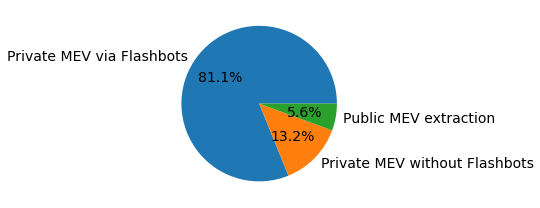

In [9]:
fig = plt.figure()
fig.patch.set_facecolor('white')
print(len(flashbots_insertion_frontrunning_attacks) + private_insertion_frontrunning_attacks + public_insertion_frontrunning_attacks)
plt.pie([len(flashbots_insertion_frontrunning_attacks), private_insertion_frontrunning_attacks, public_insertion_frontrunning_attacks], labels = ["Private MEV via Flashbots", "Private MEV without Flashbots", "Public MEV extraction"], autopct='%1.1f%%')
fig.tight_layout()
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.savefig("private_mev_distribution.pdf", dpi=1000, bbox_inches='tight')

In [10]:
miners = dict()
bots = dict()
bots_and_miners = dict()
for entry in data:
    if not entry["miner"] in miners:
        miners[entry["miner"]] = 0
    miners[entry["miner"]] += 1
    
    if not entry["transactions"][0]["to"] in bots:
        bots[entry["transactions"][0]["to"]] = 0
    bots[entry["transactions"][0]["to"]] += 1
    
    if not entry["transactions"][0]["to"] in bots_and_miners:
        bots_and_miners[entry["transactions"][0]["to"]] = dict()
    if not entry["miner"] in bots_and_miners[entry["transactions"][0]["to"]]:
        bots_and_miners[entry["transactions"][0]["to"]][entry["miner"]] = 0
    bots_and_miners[entry["transactions"][0]["to"]][entry["miner"]] += 1
    
print("Miners that do private frontrunning attacks:")

print("Number of miners:", len(miners))
for miner in miners:
    print(miner, miners[miner])
print()
print("Number of bots:", len(bots))
for bot in bots:
    print(bot, bots[bot])
    for miner in bots_and_miners[bot]:
        print("  miner:", miner, bots_and_miners[bot][miner])

Miners that do private frontrunning attacks:
Number of miners: 35
0x829BD824B016326A401d083B33D092293333A830 5126
0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8 269
0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836 692
0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c 815
0x0708F87A089a91C65d48721Aa941084648562287 106
0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5 515
0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2 569
0xEEa5B82B61424dF8020f5feDD81767f2d0D25Bfb 264
0xB7e390864a90b7b923C9f9310C6F98aafE43F707 634
0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8 500
0x4069e799Da927C06b430e247b2ee16C03e8B837d 203
0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB 548
0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a 199
0xc3348B43d3881151224b490e4aa39E03d2B1cDEa 319
0x2A20380DcA5bC24D052acfbf79ba23e988ad0050 353
0x8F03f1a3f10c05E7CCcF75C1Fd10168e06659Be7 304
0x2DaA35962A6D43EB54C48367b33d0B379C930E5e 243
0xCD458d7F11023556cC9058F729831a038Cb8Df9c 481
0x002e08000acbbaE2155Fab7AC01929564949070d 61
0x433022C4066558E7a32D850F02d2da5cA782174

In [23]:
print("Bots whose transactions have always been mined by the same miner")
for bot in bots:
    if len(bots_and_miners[bot]) == 1:
        for miner in bots_and_miners[bot]:
            if bots_and_miners[bot][miner] > 1:
                print(bot, bots[bot])
                print("  miner:", miner, bots_and_miners[bot][miner])
print()
print("Bots whose transactions have always been mined by more than one miner")
for bot in bots:
    if len(bots_and_miners[bot]) > 1:
        print(bot, bots[bot])
        for miner in bots_and_miners[bot]:
            print("  miner:", miner, bots_and_miners[bot][miner])

Bots whose transactions have always been mined by the same miner
0x42B2C65dB7F9e3b6c26Bc6151CCf30CcE0fb99EA 30
  miner: 0x7F101fE45e6649A6fB8F3F8B43ed03D353f2B90c 30
0xDD28D64E40e00aF54a0B5147539A515C4A0bC1c5 121
  miner: 0x829BD824B016326A401d083B33D092293333A830 121

Bots whose transactions have always been mined by more than one miner
0x7Cf09D7A9A74f746EDcb06949B9d64bCd9D1604f 2573
  miner: 0x829BD824B016326A401d083B33D092293333A830 1733
  miner: 0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8 115
  miner: 0xEEa5B82B61424dF8020f5feDD81767f2d0D25Bfb 82
  miner: 0x1aD91ee08f21bE3dE0BA2ba6918E714dA6B45836 68
  miner: 0xB7e390864a90b7b923C9f9310C6F98aafE43F707 66
  miner: 0xc3348B43d3881151224b490e4aa39E03d2B1cDEa 23
  miner: 0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2 40
  miner: 0x6EBaF477F83E055589C1188bCC6DDCCD8C9B131a 18
  miner: 0x2DaA35962A6D43EB54C48367b33d0B379C930E5e 18
  miner: 0x002e08000acbbaE2155Fab7AC01929564949070d 12
  miner: 0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8 60
  mi